# Train a neural network (velocity for ramps)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Set seeds

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

Set parameters

In [3]:
# file with training input and output data: format is x,y
input_file = 'RampSuccessData_FEB20_filtered.csv'

# names of input/output columns
inputs = ['mu', 'length', 'angle']
outputs = ['speed']

# these set the input/output dimensions of the network
input_size = len(inputs)
output_size = len(outputs)

Read data

In [4]:
data = pd.read_csv(input_file)
data.columns = inputs + outputs

x = np.array(data[inputs])
y = np.array(data[outputs])

Normalizing preprocessing layer from training data

In [5]:
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(x)

Penalize overpredictions more than underpredictions

In [ ]:
# def asymmetric_mse(y_true, y_pred):
#     standard_mse = keras.losses.mse(y_true, y_pred)
#     geq = keras.backend.any(keras.backend.greater(y_pred, y_true)) # true/false, are there overpredictions?
#     geq_scale = keras.backend.switch(geq,5.0,1.0) # if there are overpredictions, scale up mse
#     return geq_scale * standard_mse

Base model

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(input_size, activation='linear'))
#model.add(keras.layers.Dense(20,activation='relu'))
model.add(keras.layers.Dense(5,activation='relu'))
model.add(keras.layers.Dense(5,activation='relu'))
#model.add(keras.layers.Dense(4,activation='relu'))
model.add(keras.layers.Dense(output_size,activation='relu'))
model.compile(loss='mse',optimizer='adam')

Compile model

In [13]:
input_shape = x.shape[1:]
full_model_input = keras.Input(shape=input_shape)
normalized_input = normalizer(full_model_input)
full_model_output = model(normalized_input)
full_model = keras.Model(full_model_input, full_model_output)
full_model.compile(loss='mse',optimizer='adam',metrics=['mse'])

Split data

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, shuffle= True)

Train model

In [14]:
model_output = full_model.fit(x_train,y_train,epochs=500,batch_size=5,verbose=0,validation_data=(x_val,y_val)) # check validation

View training

<Figure size 432x288 with 0 Axes>

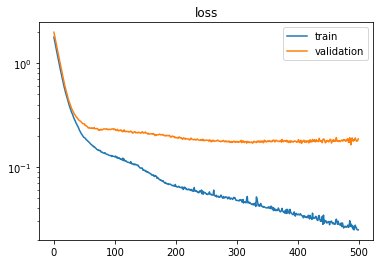

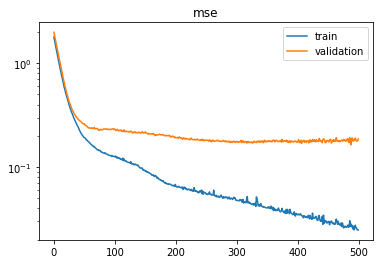

<Figure size 432x288 with 0 Axes>

In [15]:
plt.yscale('log')
plt.title('loss')
plt.plot(model_output.history['loss'], label='train')
plt.plot(model_output.history['val_loss'], label='validation')
plt.legend()
plt.figure()
plt.yscale('log')
plt.title('mse')
plt.plot(model_output.history['mse'], label='train')
plt.plot(model_output.history['val_mse'], label='validation')
plt.legend()
plt.figure()

View output

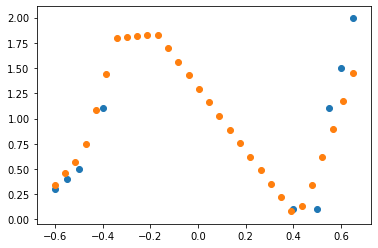

In [30]:
# plot speed vs angle given mu, threshold
mu = 1 # set mu
length = 1 # set length
angle = np.linspace(-0.6,0.65,30)

# bug: mu = 0.009 is read as 0.0090..01
#plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
plot_x = [i for i in x if (np.isclose(i[0], mu) and np.isclose(i[1], length))] # x, y
# this is not generic enough...
pred_x = [[mu, length, a] for a in angle]
pred = full_model.predict(pred_x)

plt.scatter([i[2] for i in plot_x], [y[i] for i,v in enumerate(x) if (np.isclose(v[0], mu) and np.isclose(v[1], length))])
plt.scatter([i[2] for i in pred_x], pred)

Save model

In [31]:
full_model.save('1_speed_ramp_network.h5')

Find largest divergence between prediction and training data

In [ ]:
divergence = (full_model.predict(x) - y)
max_divergence = max([i[1] for i in divergence])
print(max_divergence)
#print(max_divergence, x[np.where(divergence == max_divergence)[0]])

Time predictions

In [ ]:
%%timeit time_x = np.array([np.random.rand(3)])
full_model.predict(time_x)

Make a lot of plots

In [39]:
mus = data['mu'].unique()
lengths = data['length'].unique()
angles = data['angle'].unique()
a=0
# plot speed vs angle given mu, threshold
for mu in mus:
    for length in lengths:
        # bug: mu = 0.009 is read as 0.0090..01
        #plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
        plot_x = [i for i in x if (np.isclose(i[0], mu) and np.isclose(i[1], length))] # x, y
        pred_x = [[mu,length,angle] for angle in np.linspace(angles.min(),angles.max(),30)]
        pred = full_model.predict(pred_x)
        #plt.plot([i[1] for i in plot_values], [y[i] for i,v in enumerate(x) if v[0] == mu and v[2] == thresh])
        fig = plt.figure()
        plt.title('mu: %.3f, length: %.2f' % (mu, length))
        plt.scatter([i[2] for i in plot_x], [y[i] for i,v in enumerate(x) if (np.isclose(v[0], mu) and np.isclose(v[1], length))],
                label = 'training')
        plt.plot([i[2] for i in pred_x], pred, label = 'predicted', color='orange', marker='o')
        plt.legend()
        plt.savefig('plots/mu-%.3f_length-%.2f.png' % (mu,length))
        plt.close()